<a href="https://colab.research.google.com/github/hsiehyijin/BMI709/blob/main/Final__RSV_SMFM_abstract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install imbalanced-learn

In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 35.0 MB/s eta 0:00:00


In [ ]:
# Install catboost
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 22.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from catboost import CatBoostClassifier
import io

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Ai-ris_0804_Machine_Learning_RSV.csv to Ai-ris_0804_Machine_Learning_RSV.csv


In [ ]:
import pandas as pd
import io
data = pd.read_csv(io.BytesIO(uploaded['Ai-ris_0804_Machine_Learning_RSV.csv']))

In [ ]:
data.head()

Record ID  Delivery_Month  Maternal_Age  Gestational_Age   \
0         1               1          37.4             38.14   
1         2               1          41.9             37.71   
2         3               1          38.9             39.43   
3         4               1          37.6             40.71   
4         5               1          31.5             38.00   

   OB_Provider_Group  Race  Self_Report_Language  Payor_Category  Parity  \
0                  3     5                     1               1       1   
1                  1     3                     1               1       1   
2                  1     1                     1               1       1   
3                  3     1                     1               1       0   
4                  1     1                     1               1       1   

   Perinatal_demise  Group  No_Births  Infant_Sex  
0                 0  NOVAX          1           1  
1                 0  NOVAX          1           2  
2                 0  NOVAX          1           2  
3                 0  NOVAX          1           1  
4                 0  NOVAX          1           1

In [ ]:
# Drop the index column if present
data = data.drop(columns=['Record ID'], errors='ignore')

In [ ]:
# Identify continuous and categorical variables
continuous_vars = ['Maternal_Age','Gestational_Age']
categorical_vars = ['Delivery_Month', 'OB_Provider_Group',  'Race', 'Self_Report_Language', 'Payor_Category', 'Parity','Perinatal_demise', 'No_Births','Infant_Sex']


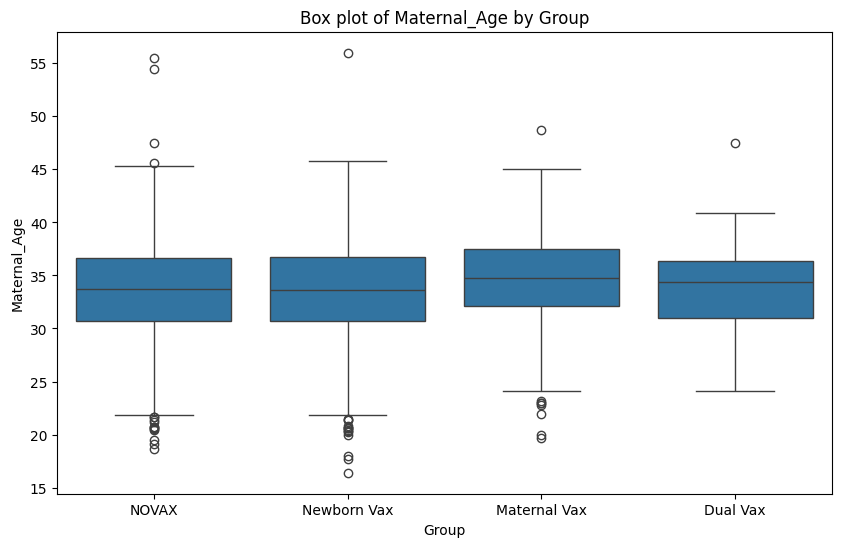

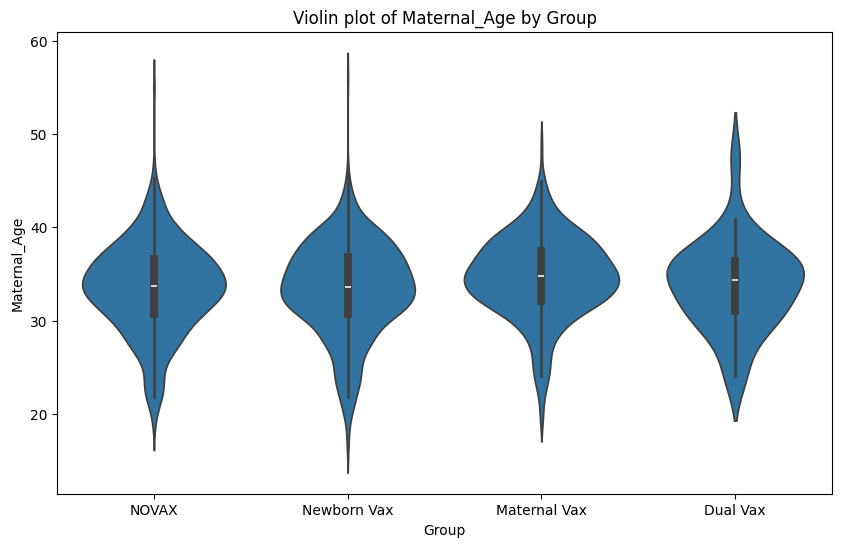

ValueError: Could not interpret value `Gestational_Age` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Outcome variable
outcome_var = 'Group'

# Plotting continuous variables
for var in continuous_vars:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=outcome_var, y=var, data=data)
    plt.title(f'Box plot of {var} by {outcome_var}')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.violinplot(x=outcome_var, y=var, data=data)
    plt.title(f'Violin plot of {var} by {outcome_var}')
    plt.show()

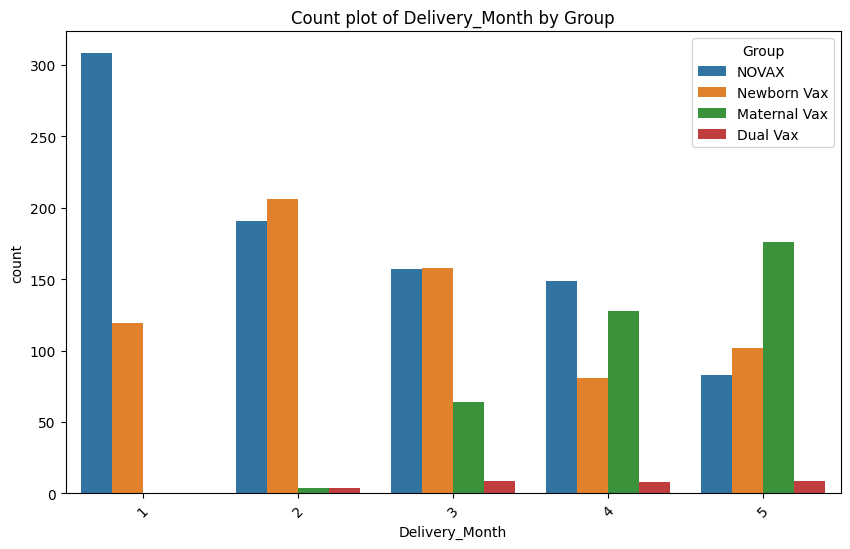

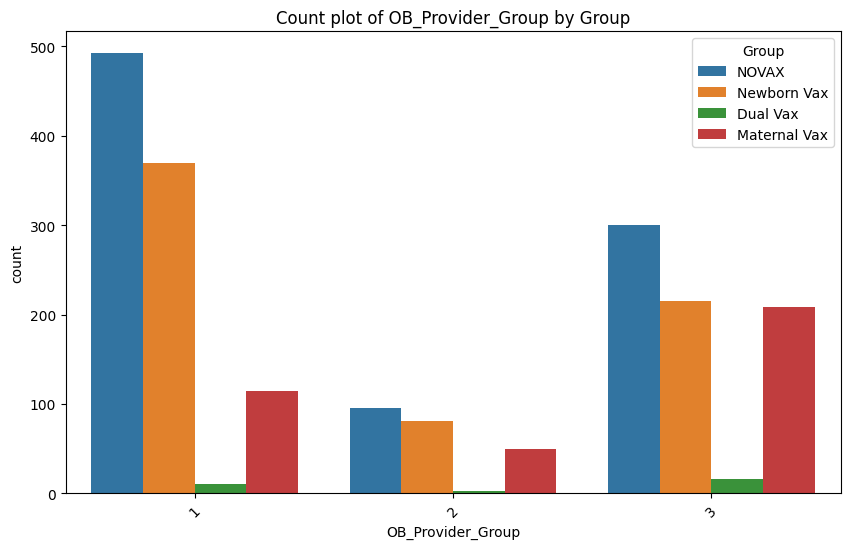

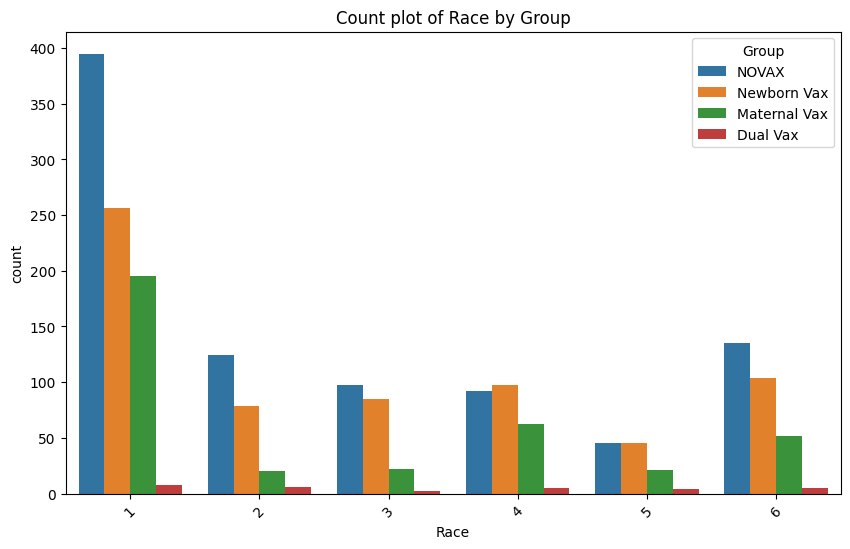

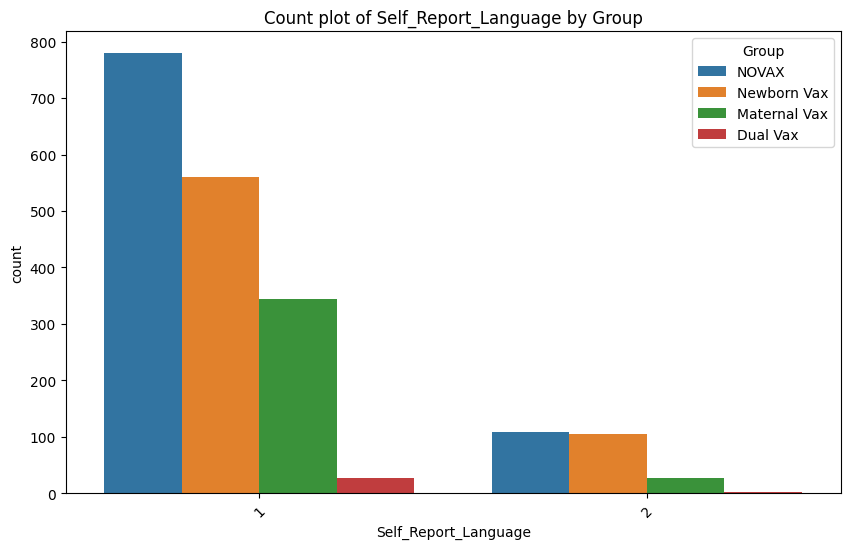

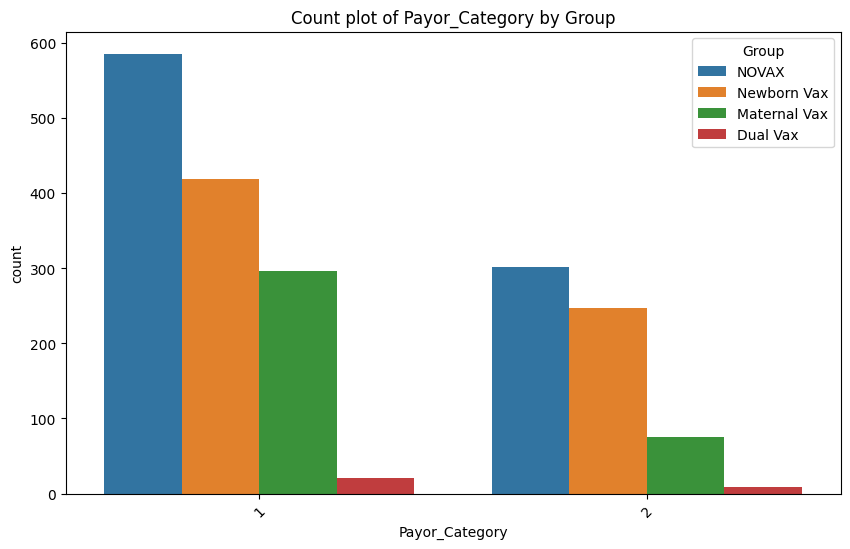

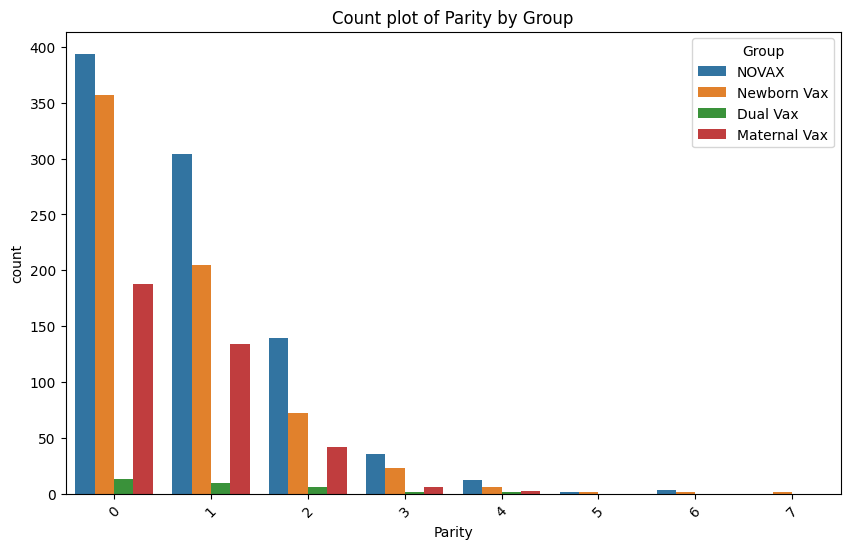

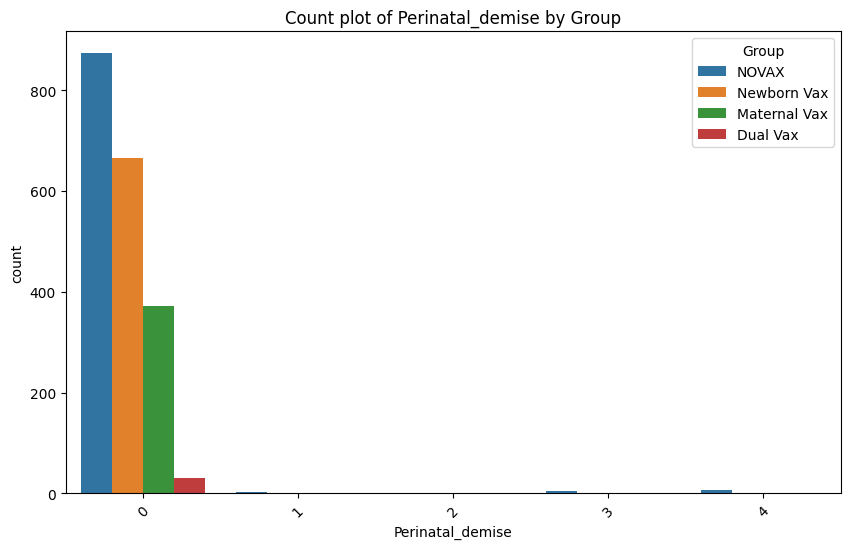

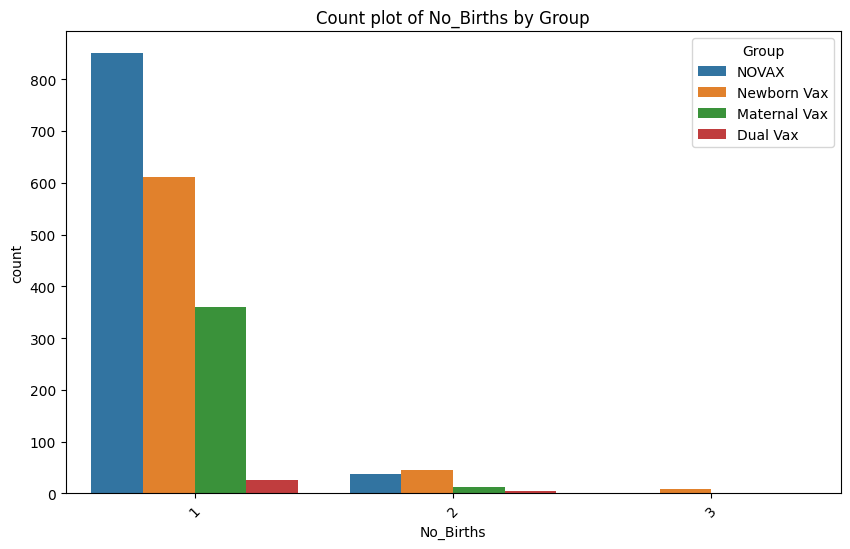

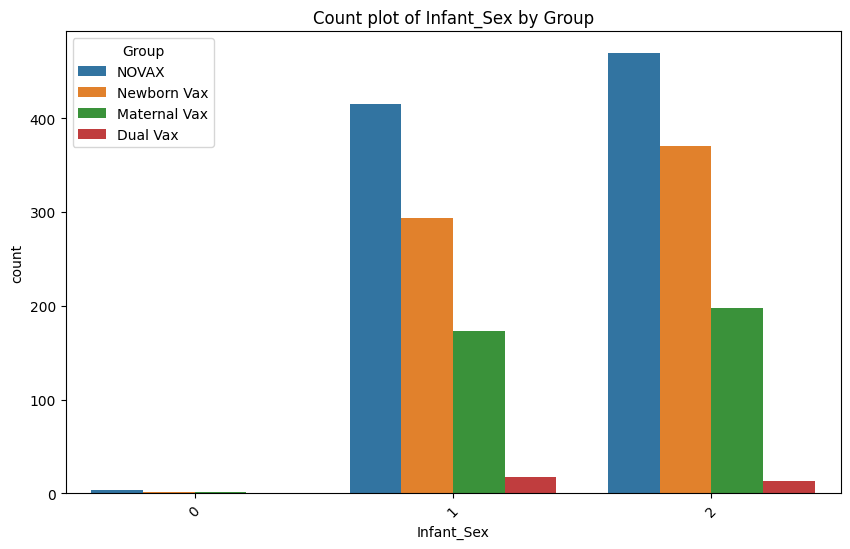

In [ ]:
# Plotting categorical variables
for var in categorical_vars:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=var, hue=outcome_var, data=data)
    plt.title(f'Count plot of {var} by {outcome_var}')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# Verify if columns exist in the dataframe
continuous_vars = [col for col in continuous_vars if col in data.columns]
categorical_vars = [col for col in categorical_vars if col in data.columns]

# Ensure continuous variables are of types 'int64' or 'float64'
data[continuous_vars] = data[continuous_vars].apply(pd.to_numeric, errors='coerce')

# Ensure categorical variables are of types 'object' or 'category'
data[categorical_vars] = data[categorical_vars].astype('category')


In [ ]:
# Separate features and target variable
X = data.drop(columns=['Group'])
y = data['Group']

In [ ]:
# Encode target labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
# Define class names based on the original categories
class_names = label_encoder.classes_

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

In [ ]:
# Preprocessing for continuous variables using Iterative Imputation
continuous_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(random_state=42))
])

# Define the preprocessing pipeline for categorical variables
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])


In [ ]:
# Combining preprocessing for both types of variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', continuous_transformer, continuous_vars),
        ('cat', categorical_transformer, categorical_vars)
    ]
)


In [ ]:
# Apply preprocessing to the training and test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Convert preprocessed data back to DataFrame to preserve categorical column names
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=continuous_vars + categorical_vars)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=continuous_vars + categorical_vars)

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed_df, y_train)

In [ ]:
# CatBoost model
catboost_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, random_state=42, silent=True)
catboost_model.fit(X_train_resampled, y_train_resampled)

In [ ]:
# Predictions
y_pred = catboost_model.predict(X_test_preprocessed)
y_proba = catboost_model.predict_proba(X_test_preprocessed)

# Metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred, average='macro'),
    'Recall': recall_score(y_test, y_pred, average='macro'),
    'F1 Score': f1_score(y_test, y_pred, average='macro'),
    'MCC': matthews_corrcoef(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_proba, multi_class='ovr')
}

print("CatBoost Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value}")


CatBoost Metrics:
Accuracy: 0.5264054514480409
Precision: 0.46586063190540805
Recall: 0.5069799498746868
F1 Score: 0.4772814274285648
MCC: 0.29679782373754443
ROC AUC: 0.7486598285276626


In [ ]:
# SHAP analysis
explainer = shap.Explainer(catboost_model)
shap_values = explainer(X_test_preprocessed)

# Ensure feature names are correctly passed to SHAP summary plot
feature_names = X.columns.tolist()

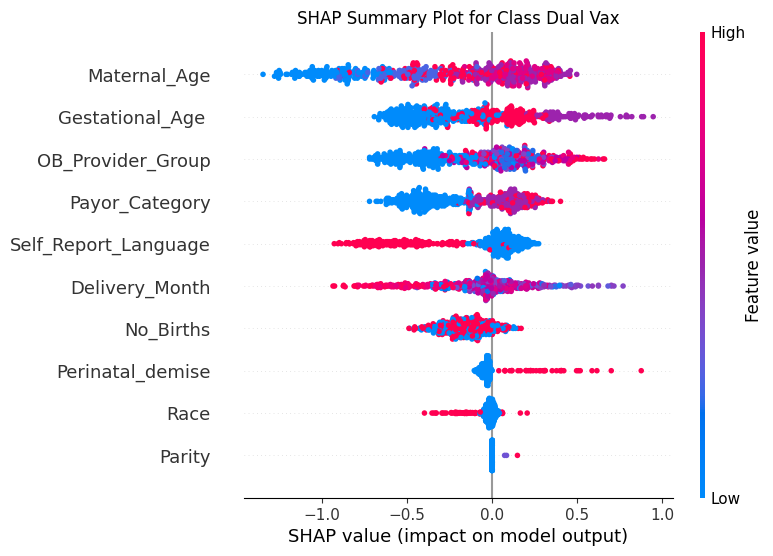

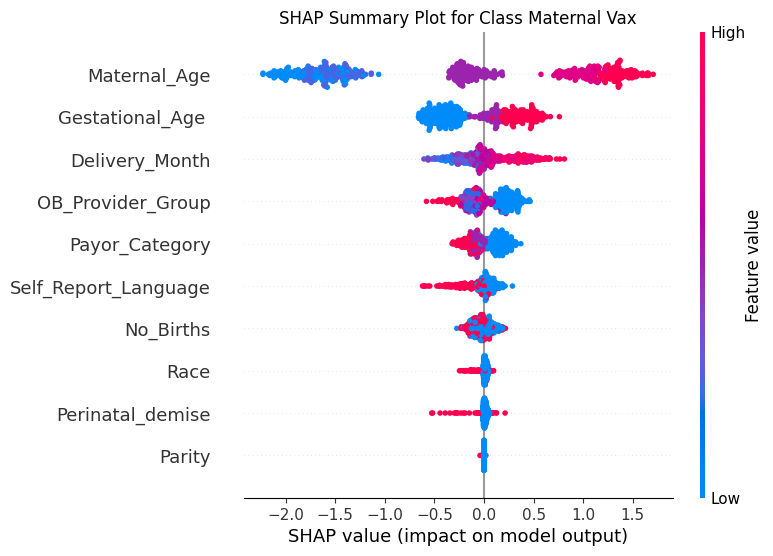

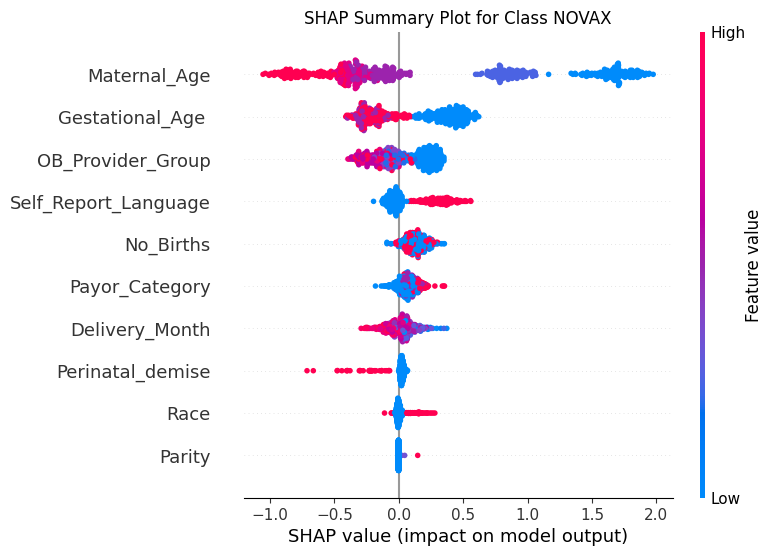

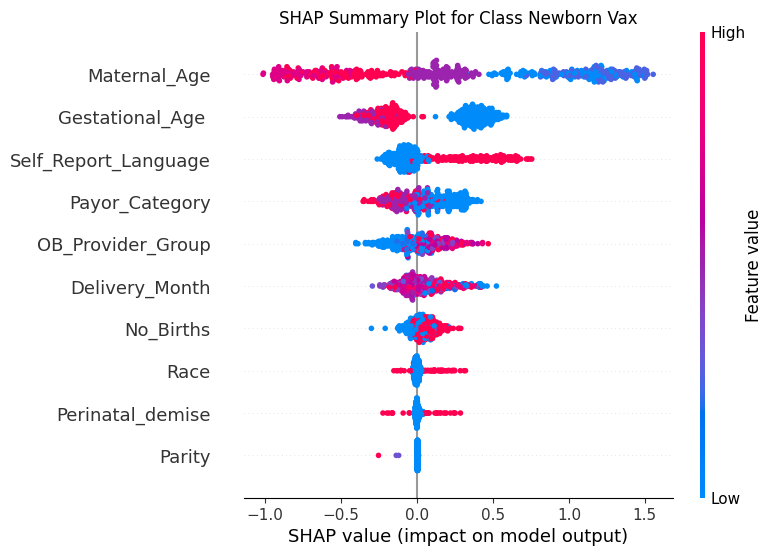

In [ ]:
# Visualize SHAP values for each class separately
for i, class_name in enumerate(class_names):
    plt.figure()
    shap.summary_plot(shap_values[:, :, i], X_test_preprocessed, feature_names=feature_names, show=False)
    plt.title(f'SHAP Summary Plot for Class {class_name}')
    plt.show()

# Waterfall plot for the first observation in the test set for each class
#for i, class_name in enumerate(class_names):
    #shap.waterfall_plot(shap_values[0][:, i])
    #plt.title(f'SHAP Waterfall Plot for First Observation - Class {class_name}')
    #plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OrdinalEncoder, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [ ]:
# Define model pipelines including CatBoost
pipelines = {
    'Logistic_Standard': Pipeline([('model', LogisticRegression(max_iter=1000, random_state=42))]),
    'Logistic_Lasso': Pipeline([('model', LogisticRegression(penalty='l1', solver='liblinear', random_state=42))]),
    'Logistic_Ridge': Pipeline([('model', LogisticRegression(penalty='l2', random_state=42))]),
    'RandomForest': Pipeline([('model', RandomForestClassifier(n_estimators=100, random_state=42))]),
    'SVM_Radial': Pipeline([('model', SVC(kernel='rbf', probability=True, random_state=42))]),
    'SVM_Linear': Pipeline([('model', SVC(kernel='linear', probability=True, random_state=42))]),
    'XGBoost': Pipeline([('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))]),
    'CatBoost': Pipeline([('model', CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, random_state=42, silent=True))]),
    'BNB': Pipeline([('model', BernoulliNB())]),
    'KNN': Pipeline([('model', KNeighborsClassifier())]),
    'MLP': Pipeline([('model', MLPClassifier(max_iter=300, random_state=42))])
}

In [ ]:
# Function to calculate additional metrics
def calculate_metrics(pipeline, X_test, y_test):
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test) if hasattr(pipeline.named_steps['model'], "predict_proba") else None

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='macro'),
        'Recall': recall_score(y_test, y_pred, average='macro'),
        'F1 Score': f1_score(y_test, y_pred, average='macro'),
        'MCC': matthews_corrcoef(y_test, y_pred)
    }
    if y_proba is not None:
        metrics['ROC AUC'] = roc_auc_score(y_test, y_proba, multi_class='ovr')

    return metrics

Training Logistic_Standard...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegr

Logistic_Standard Metrics: {'Accuracy': 0.47189097103918226, 'Precision': 0.4131909326189857, 'Recall': 0.4822389306599833, 'F1 Score': 0.3984253295545962, 'MCC': 0.25862108654349314, 'ROC AUC': 0.7280685915268195}
Training Logistic_Lasso...
Logistic_Lasso Metrics: {'Accuracy': 0.47018739352640543, 'Precision': 0.4043384796826512, 'Recall': 0.48496919381787806, 'F1 Score': 0.3908485739256137, 'MCC': 0.25596115034910777, 'ROC AUC': 0.7357139282350125}
Training Logistic_Ridge...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Logistic_Ridge Metrics: {'Accuracy': 0.44804088586030666, 'Precision': 0.38877495368526754, 'Recall': 0.4358333333333333, 'F1 Score': 0.3731820326912351, 'MCC': 0.2236265845478744, 'ROC AUC': 0.7238428882685172}
Training RandomForest...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForest Metrics: {'Accuracy': 0.5127768313458262, 'Precision': 0.45283744585775043, 'Recall': 0.4449164578111947, 'F1 Score': 0.447513123039422, 'MCC': 0.24499299446228853, 'ROC AUC': 0.7112203354474006}
Training SVM_Radial...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


SVM_Radial Metrics: {'Accuracy': 0.4020442930153322, 'Precision': 0.39042801823721984, 'Recall': 0.4553456558061821, 'F1 Score': 0.34975812846274995, 'MCC': 0.20525883174959395, 'ROC AUC': 0.7150741190595253}
Training SVM_Linear...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:17:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


SVM_Linear Metrics: {'Accuracy': 0.44122657580919933, 'Precision': 0.4029117891009, 'Recall': 0.46769945697577275, 'F1 Score': 0.3777060383587348, 'MCC': 0.241049086976326, 'ROC AUC': 0.7122941580328976}
Training XGBoost...
XGBoost Metrics: {'Accuracy': 0.5212947189097104, 'Precision': 0.47066416040100245, 'Recall': 0.45225198412698414, 'F1 Score': 0.4581930727500348, 'MCC': 0.25634919201631756, 'ROC AUC': 0.7153826314261079}
Training CatBoost...
CatBoost Metrics: {'Accuracy': 0.5315161839863713, 'Precision': 0.4459002836498996, 'Recall': 0.48192773600668337, 'F1 Score': 0.45443474588042143, 'MCC': 0.30572254238545715, 'ROC AUC': 0.7519356317320198}
Training BNB...
BNB Metrics: {'Accuracy': 0.20442930153321975, 'Precision': 0.3495484400656814, 'Recall': 0.28170843776106935, 'F1 Score': 0.12729773607845626, 'MCC': 0.041958505172370215, 'ROC AUC': 0.5040618930387049}
Training KNN...
KNN Metrics: {'Accuracy': 0.44122657580919933, 'Precision': 0.38849666452875553, 'Recall': 0.4494423558897

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  wa

MLP Metrics: {'Accuracy': 0.47700170357751276, 'Precision': 0.4178378031246268, 'Recall': 0.5103973475355055, 'F1 Score': 0.40929536547477874, 'MCC': 0.26066053519665383, 'ROC AUC': 0.7549102339153329}
                   Accuracy  Precision    Recall  F1 Score       MCC   ROC AUC
Logistic_Standard  0.471891   0.413191  0.482239  0.398425  0.258621  0.728069
Logistic_Lasso     0.470187   0.404338  0.484969  0.390849  0.255961  0.735714
Logistic_Ridge     0.448041   0.388775  0.435833  0.373182  0.223627  0.723843
RandomForest       0.512777   0.452837  0.444916  0.447513  0.244993  0.711220
SVM_Radial         0.402044   0.390428  0.455346  0.349758  0.205259  0.715074
SVM_Linear         0.441227   0.402912  0.467699  0.377706  0.241049  0.712294
XGBoost            0.521295   0.470664  0.452252  0.458193  0.256349  0.715383
CatBoost           0.531516   0.445900  0.481928  0.454435  0.305723  0.751936
BNB                0.204429   0.349548  0.281708  0.127298  0.041959  0.504062
KNN     

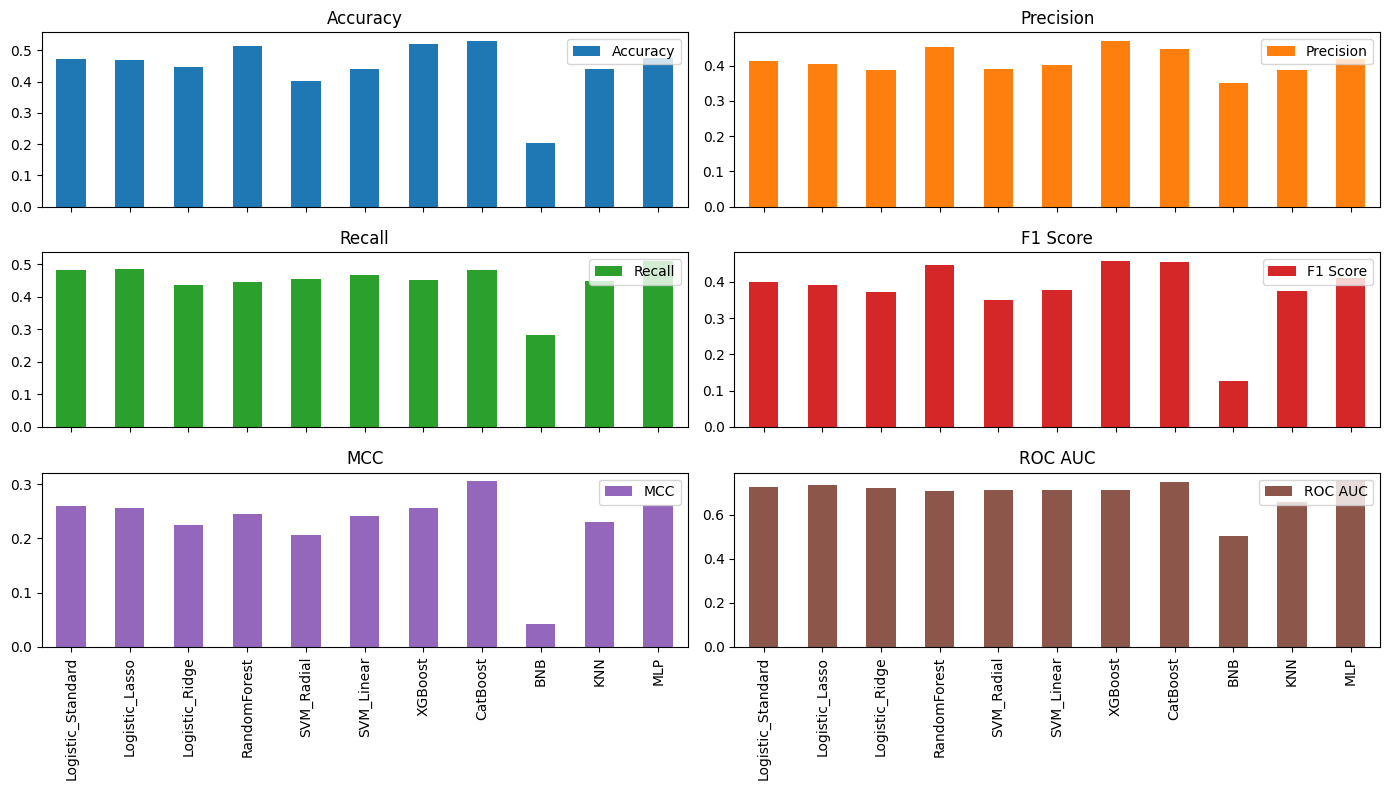

In [ ]:
# Dictionary to store metrics
additional_metrics = {}

# Fit and evaluate each model
for name, pipeline in pipelines.items():
    print(f"Training {name}...")
    pipeline.fit(X_train_resampled, y_train_resampled)
    metrics = calculate_metrics(pipeline, X_test_preprocessed, y_test)
    additional_metrics[name] = metrics
    print(f"{name} Metrics: {metrics}")

# Display metrics
metrics_df = pd.DataFrame(additional_metrics).T
print(metrics_df)

# Plot metrics
metrics_df.plot(kind='bar', figsize=(14, 8), subplots=True, layout=(3, 2))
plt.tight_layout()
plt.show()

Shape of shap_mean: (13,)
Number of features: 13


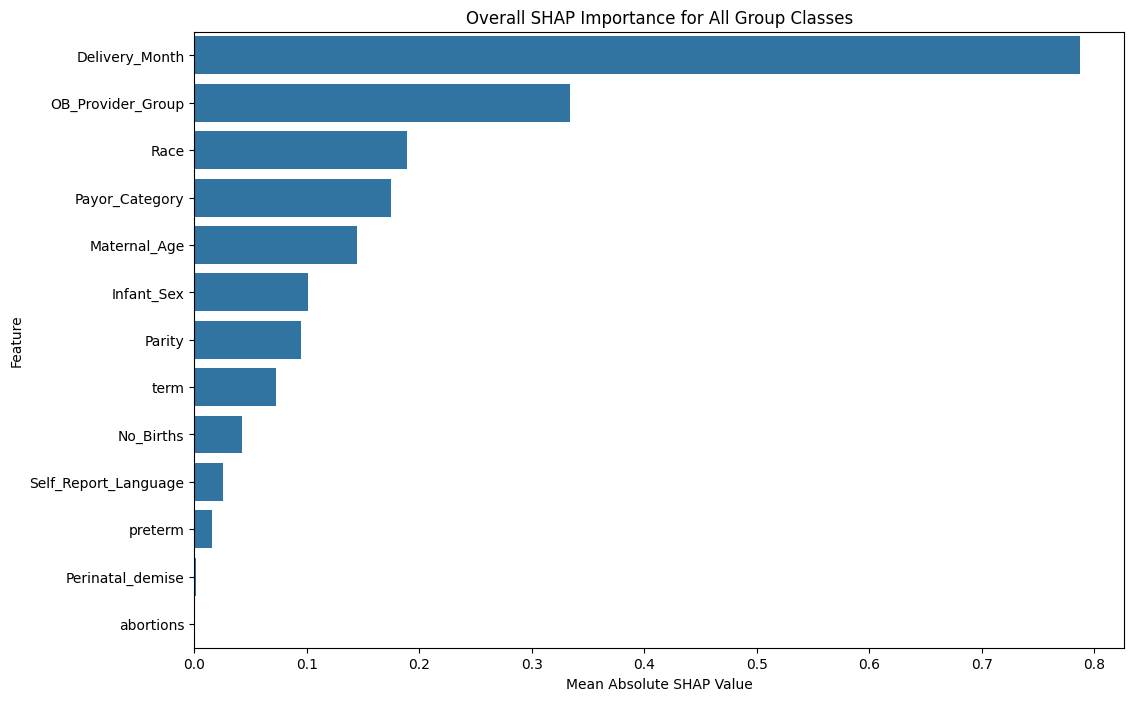

In [ ]:
# SHAP analysis
explainer = shap.Explainer(catboost_model)
shap_values = explainer(X_test_preprocessed)

# Summing the absolute SHAP values for each feature across all instances and taking the mean across all classes
shap_mean = np.abs(shap_values.values).mean(axis=(0, 2))

# Check the shape of shap_mean and feature_names
print("Shape of shap_mean:", shap_mean.shape)
print("Number of features:", len(feature_names))

# Ensure feature_names matches the number of features
feature_names = continuous_vars + categorical_vars
if len(feature_names) != shap_mean.shape[0]:
    raise ValueError("Mismatch between the number of features and SHAP values.")

# Create DataFrame for SHAP importance
shap_importance = pd.DataFrame(list(zip(feature_names, shap_mean)), columns=['Feature', 'SHAP Importance'])
shap_importance.sort_values(by='SHAP Importance', ascending=False, inplace=True)

# Plot the overall SHAP importance
plt.figure(figsize=(12, 8))
sns.barplot(x=shap_importance['SHAP Importance'], y=shap_importance['Feature'])
plt.title('Overall SHAP Importance for All Group Classes')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature')
plt.show()

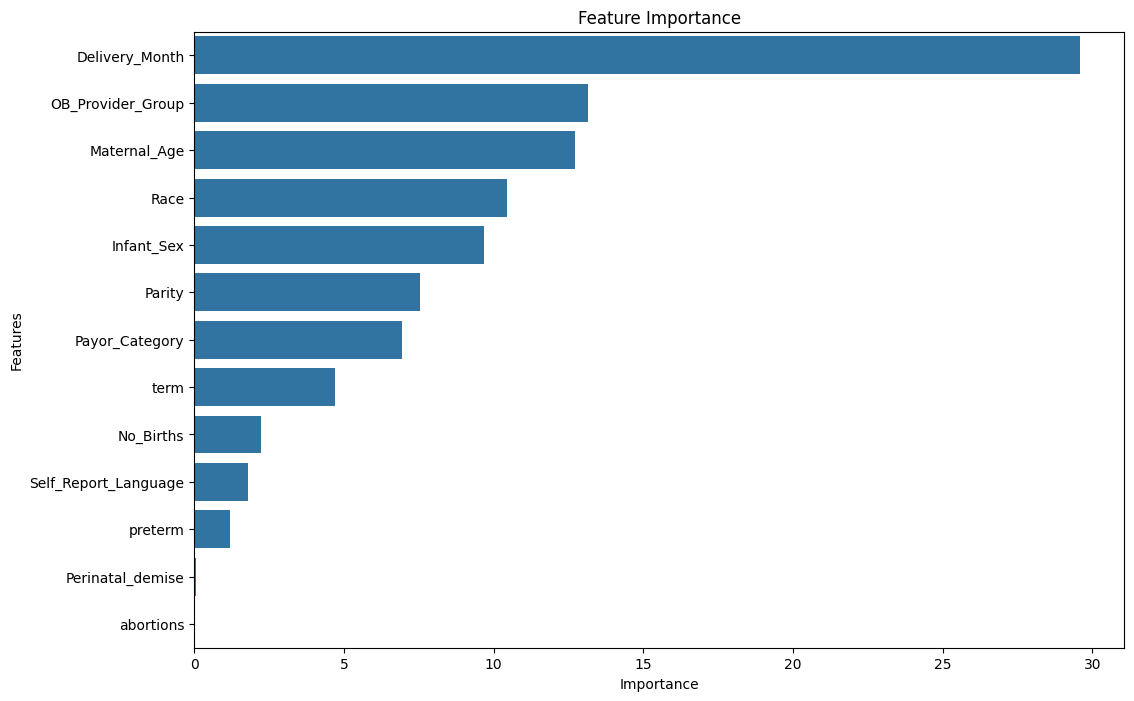

In [ ]:
# Feature importance
feature_importances = catboost_model.get_feature_importance(prettified=True)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances['Importances'], y=feature_importances['Feature Id'])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


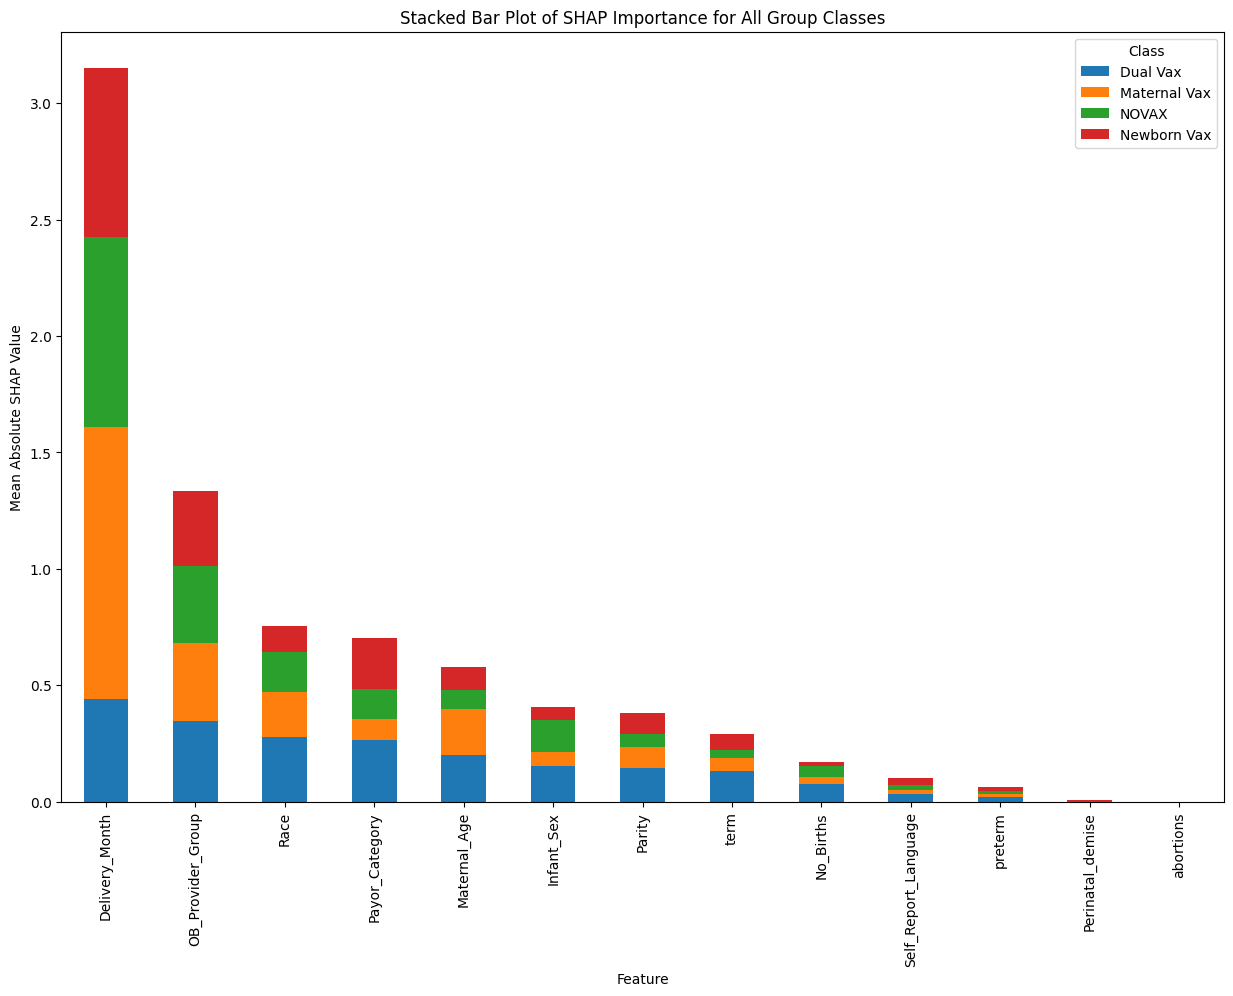

In [ ]:

# SHAP analysis
explainer = shap.Explainer(catboost_model)
shap_values = explainer(X_test_preprocessed)

# Get the absolute SHAP values
shap_abs = np.abs(shap_values.values)

# Summing the absolute SHAP values for each feature across all instances and classes
shap_sum_per_class = shap_abs.mean(axis=0)

# Ensure feature_names matches the number of features
feature_names = continuous_vars + categorical_vars

# Create DataFrame for SHAP importance for each class
shap_importance_df = pd.DataFrame(shap_sum_per_class, columns=class_names, index=feature_names)
shap_importance_df['Total'] = shap_importance_df.sum(axis=1)
shap_importance_df.sort_values(by='Total', ascending=False, inplace=True)
shap_importance_df.drop(columns=['Total'], inplace=True)

# Plot the overall SHAP importance
shap_importance_df.plot(kind='bar', stacked=True, figsize=(15, 10))
plt.title('Stacked Bar Plot of SHAP Importance for All Group Classes')
plt.xlabel('Feature')
plt.ylabel('Mean Absolute SHAP Value')
plt.legend(title='Class')
plt.show()

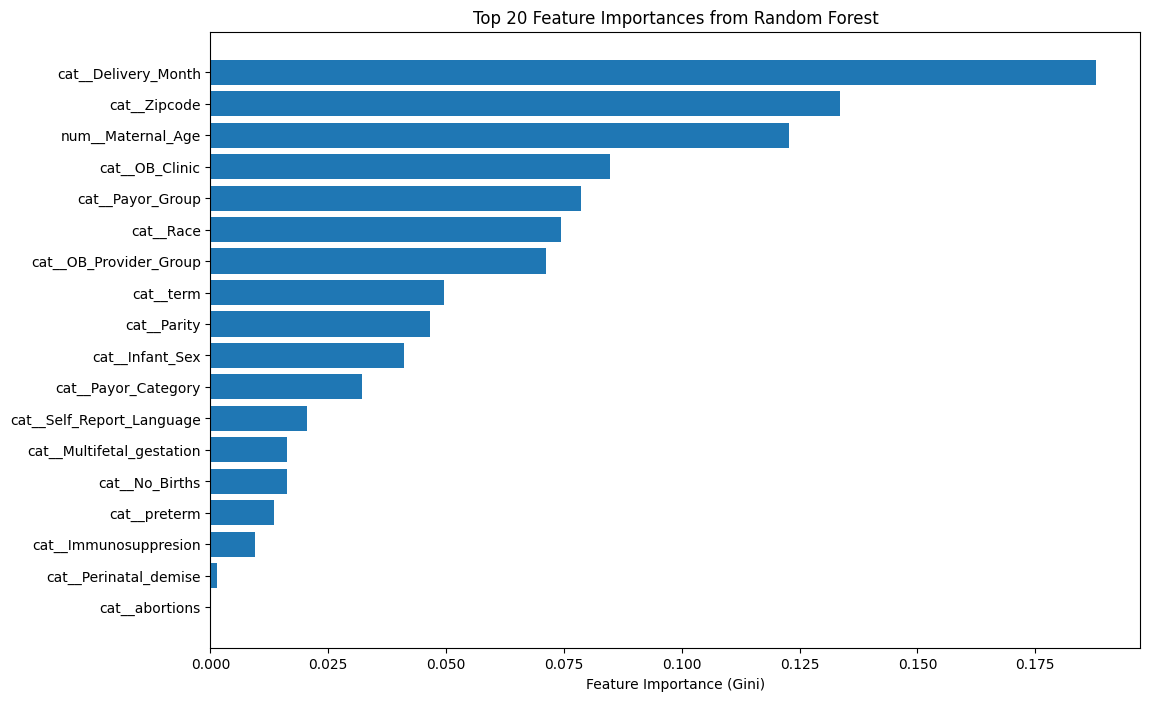

In [ ]:
# Train Random Forest model to get feature importances
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Get feature importances from the Random Forest model
rf_importances = rf_model.feature_importances_
rf_feature_names = preprocessor.get_feature_names_out()

# Plot top 20 feature importances for Random Forest
sorted_rf_idx = rf_importances.argsort()[-20:]
plt.figure(figsize=(12, 8))
plt.barh(rf_feature_names[sorted_rf_idx], rf_importances[sorted_rf_idx])
plt.xlabel("Feature Importance (Gini)")
plt.title("Top 20 Feature Importances from Random Forest")
plt.show()

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

# Create the LimeTabularExplainer
explainer = LimeTabularExplainer(X_train_preprocessed, feature_names=X.columns, class_names=class_names, discretize_continuous=True)

# Choose an instance to explain
i = 2  # index of the instance
exp = explainer.explain_instance(X_test_preprocessed[i], rf_model.predict_proba, num_features=10)

# Show the explanation
exp.show_in_notebook(show_table=True, show_all=False)

In [ ]:
!pip install --upgrade scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 98.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


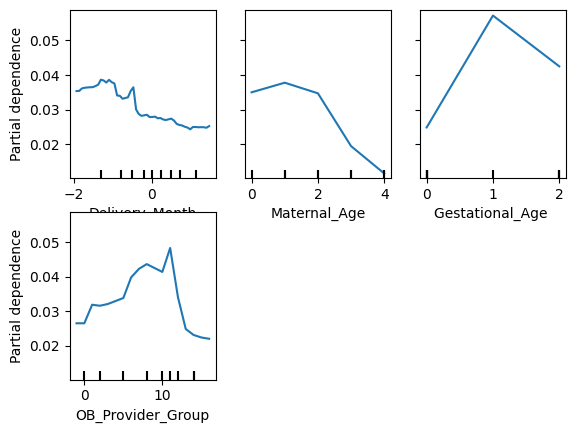

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
# Extract the RandomForest model from the pipeline
rf_model = rf_pipeline.named_steps['model']

# List of features for which you want to plot PDP
features_to_plot = [0, 1, 2, 3]  # Indices of features to plot

# Plot partial dependence plots for selected features for a specific class
target_class = 0  # Specify the class index you want to plot PDP for (e.g., 0 for the first class)

PartialDependenceDisplay.from_estimator(
    rf_model,
    X_test_preprocessed,
    features_to_plot,
    target=target_class,
    feature_names=X.columns,
    grid_resolution=50
)
plt.show()

100%|===================| 2338/2348 [01:16<00:00]       

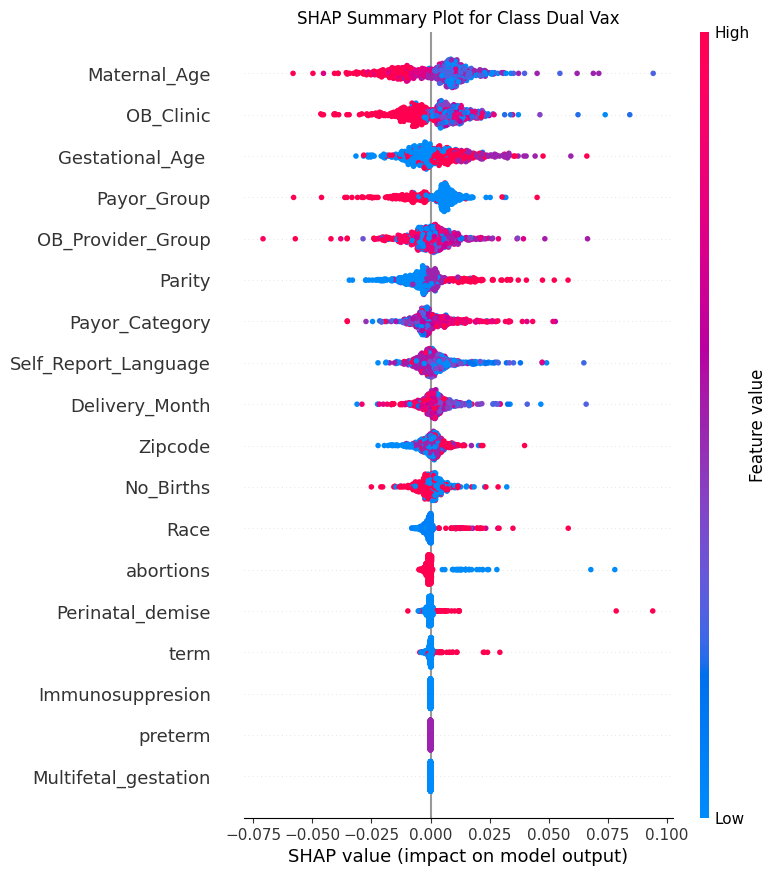

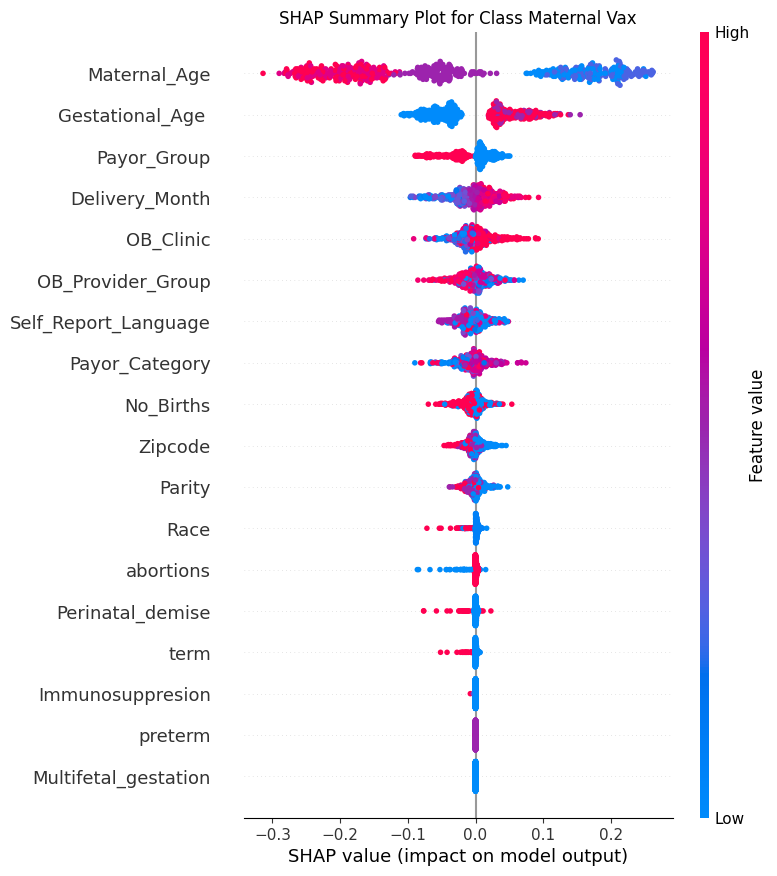

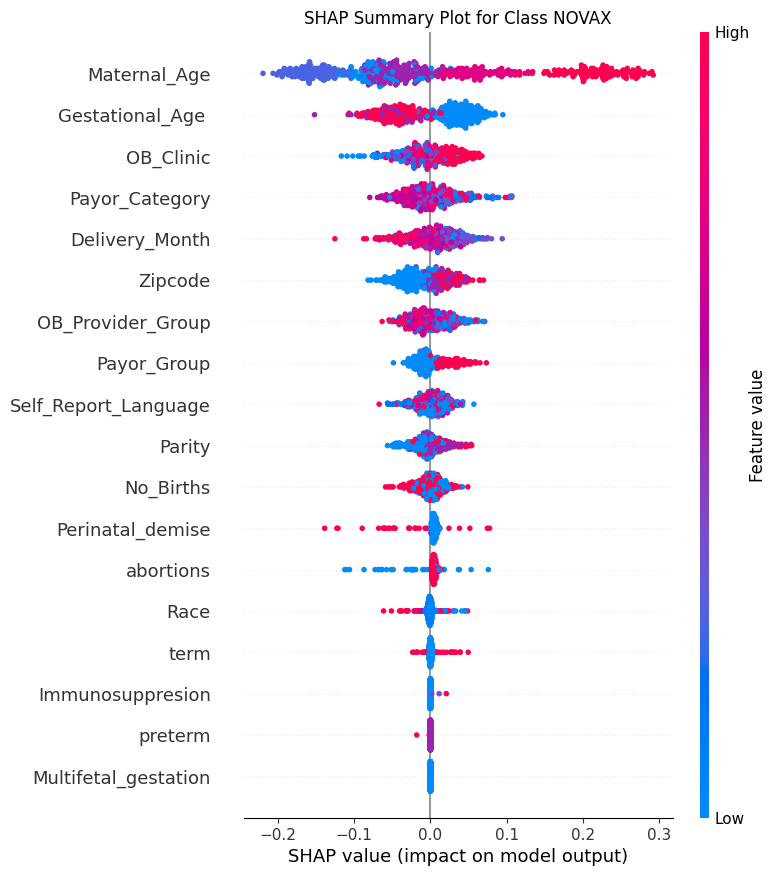

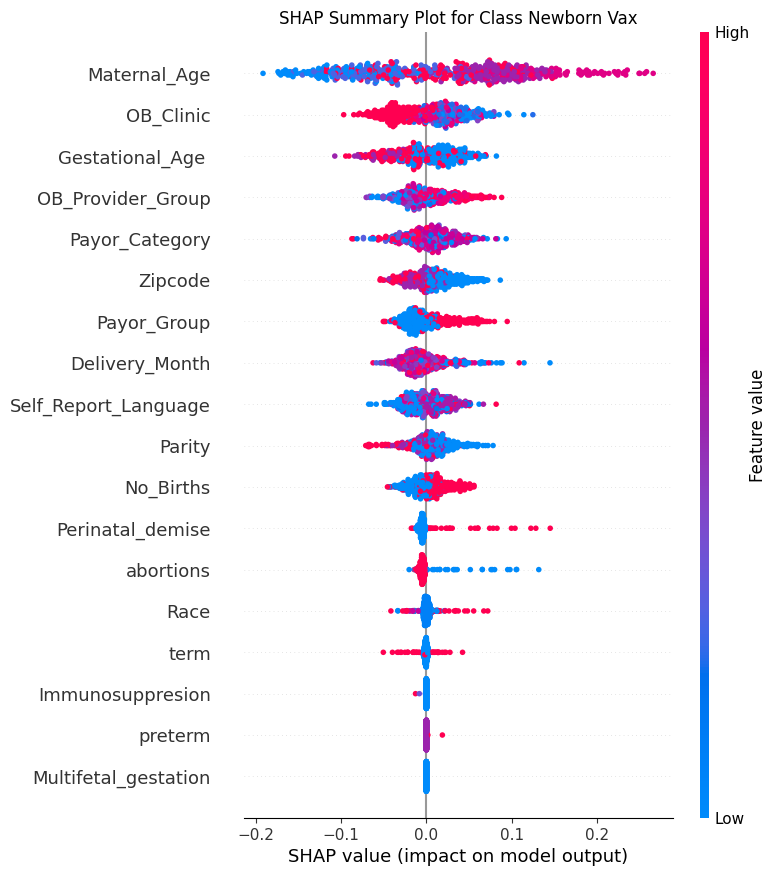

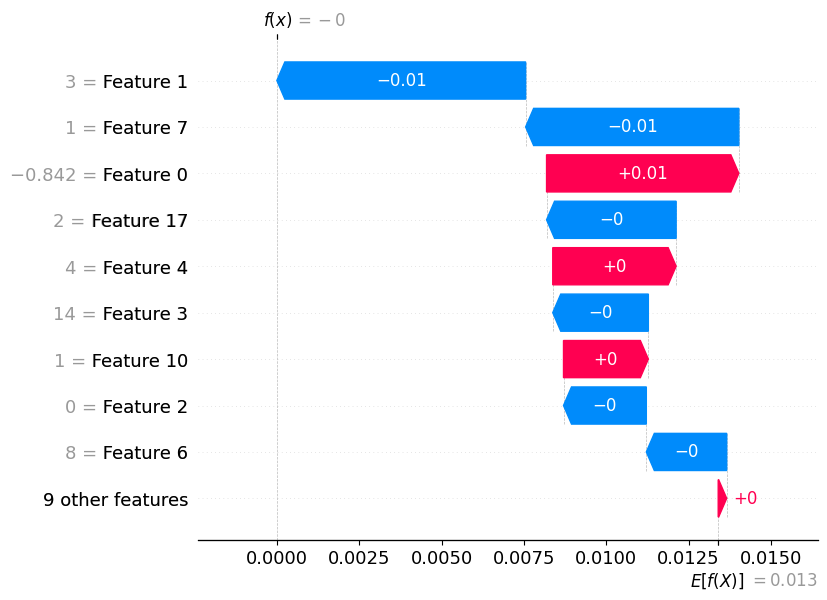

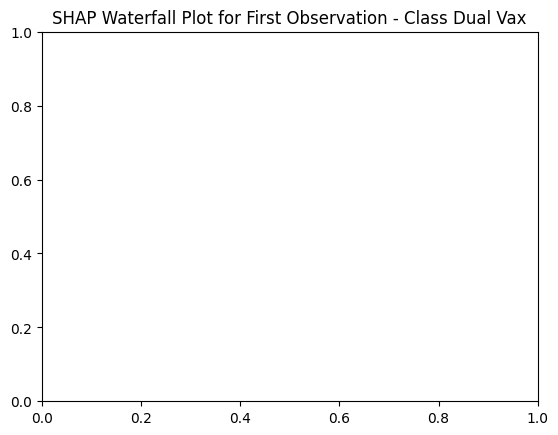

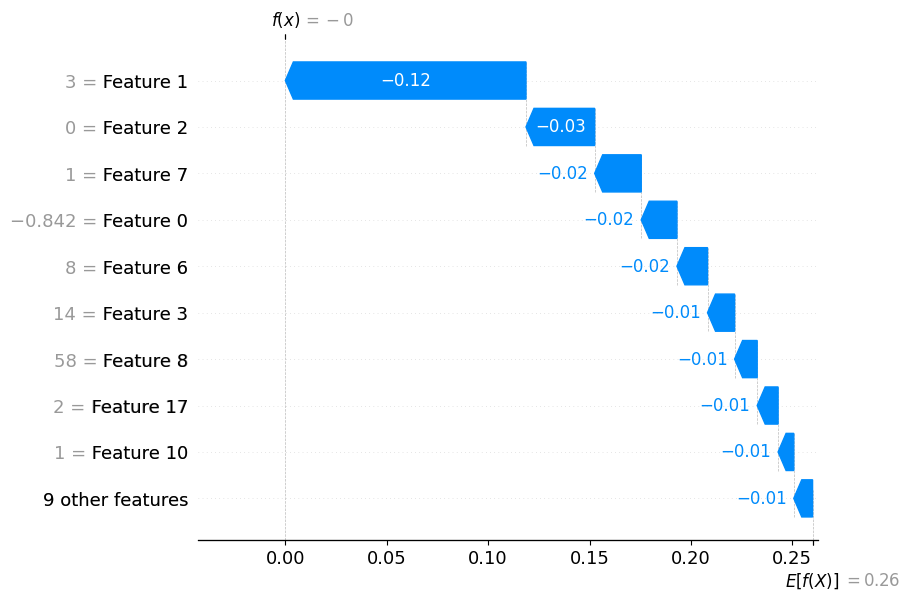

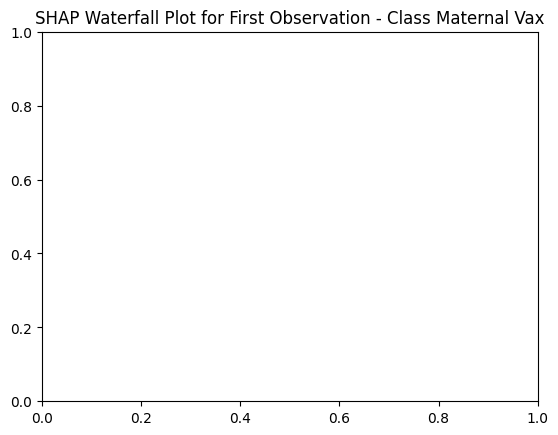

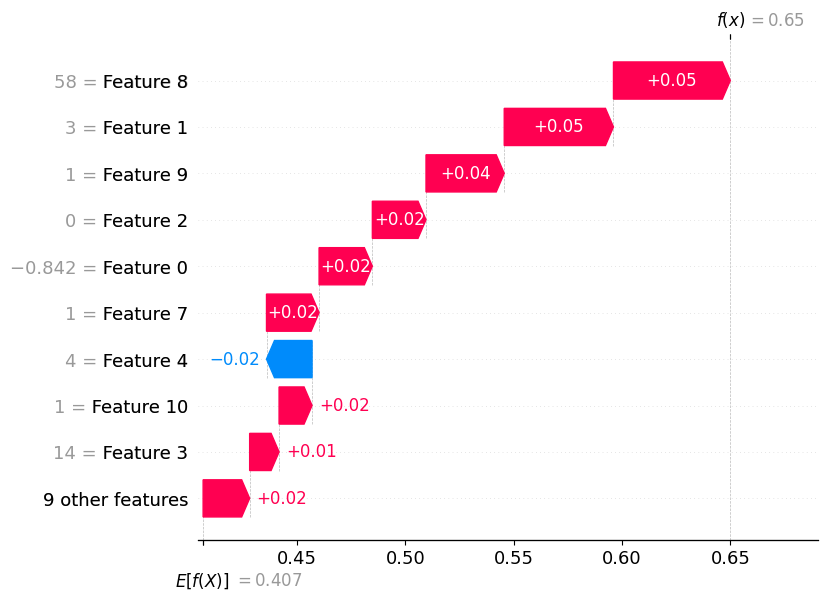

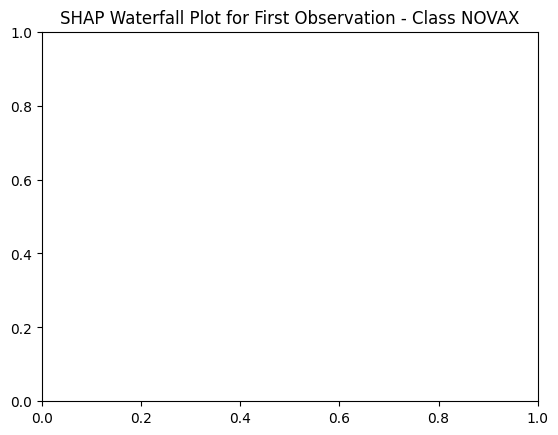

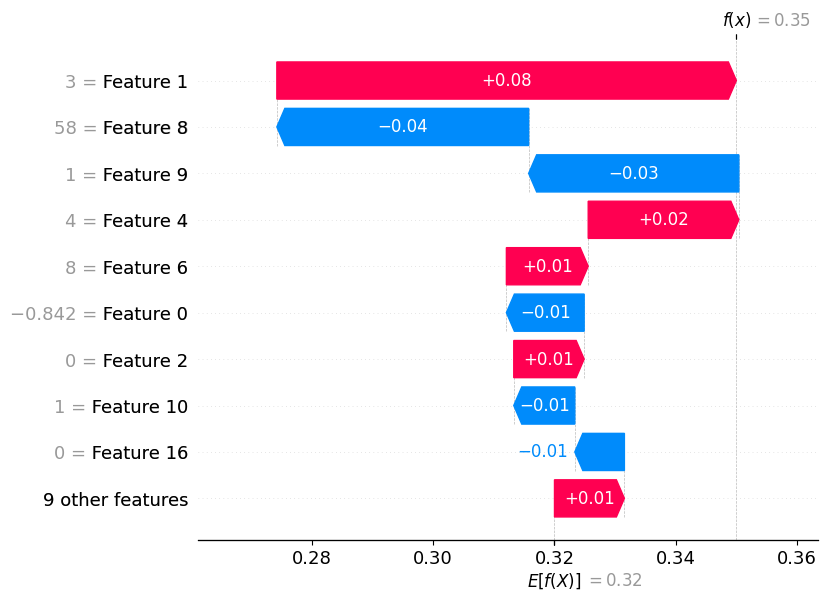

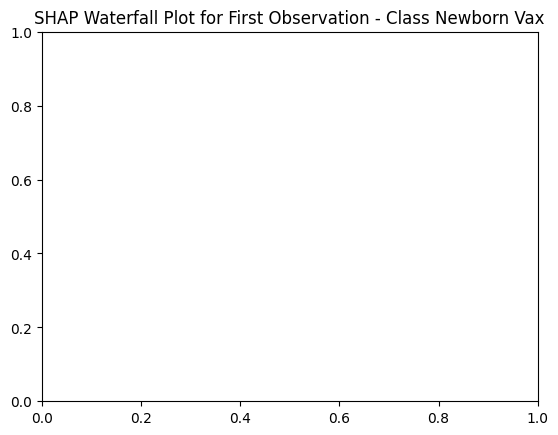

In [ ]:


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Create the SHAP explainer
explainer = shap.Explainer(rf_model, X_train_preprocessed)
shap_values = explainer(X_test_preprocessed)

# Ensure feature names are correctly passed to SHAP summary plot
feature_names = X.columns.tolist()

# Visualize SHAP values for each class separately
for i, class_name in enumerate(class_names):
    plt.figure()
    shap.summary_plot(shap_values[:, :, i], X_test_preprocessed, feature_names=feature_names, show=False)
    plt.title(f'SHAP Summary Plot for Class {class_name}')
    plt.show()

# Waterfall plot for the first observation in the test set for each class
for i, class_name in enumerate(class_names):
    shap.waterfall_plot(shap_values[0][:, i])
    plt.title(f'SHAP Waterfall Plot for First Observation - Class {class_name}')
    plt.show()

 99%|===================| 2333/2348 [01:16<00:00]       

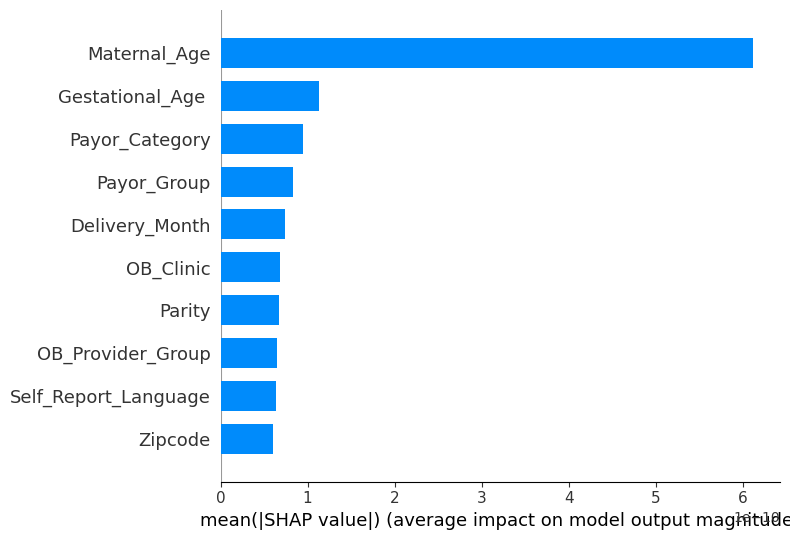

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Create the SHAP explainer
explainer = shap.Explainer(rf_model, X_train_preprocessed)
shap_values = explainer(X_test_preprocessed)

# Combine SHAP values for all classes
shap_values_combined = np.mean([shap_values.values[:, :, i] for i in range(len(class_names))], axis=0)

# Generate the SHAP bar summary plot
shap.initjs()
shap.summary_plot(shap_values_combined, X_test_preprocessed, feature_names=X.columns.tolist(), plot_type="bar", max_display=10)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:17:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


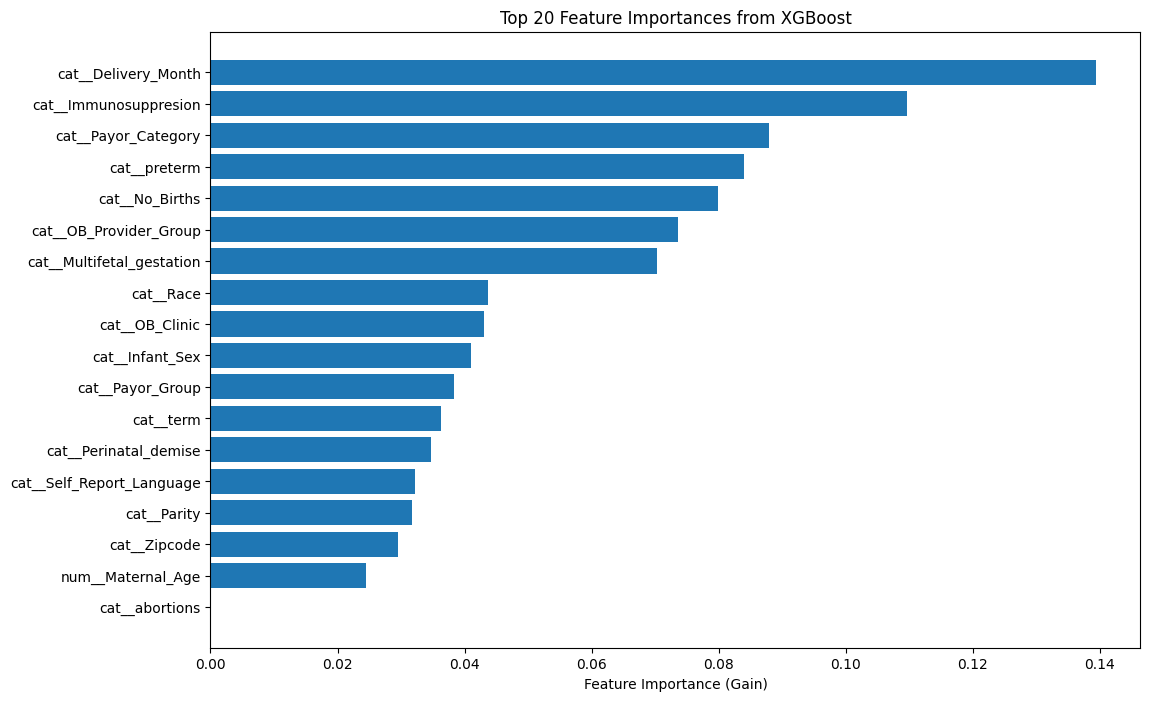

In [ ]:
# Train XGBoost model to get feature importances
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Get feature importances from the XGBoost model
xgb_importances = xgb_model.feature_importances_
xgb_feature_names = preprocessor.get_feature_names_out()

# Plot top 20 feature importances for XGBoost
sorted_xgb_idx = xgb_importances.argsort()[-20:]
plt.figure(figsize=(12, 8))
plt.barh(xgb_feature_names[sorted_xgb_idx], xgb_importances[sorted_xgb_idx])
plt.xlabel("Feature Importance (Gain)")
plt.title("Top 20 Feature Importances from XGBoost")
plt.show()

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [06:44:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
 98%|===================| 2304/2348 [00:36<00:00]       

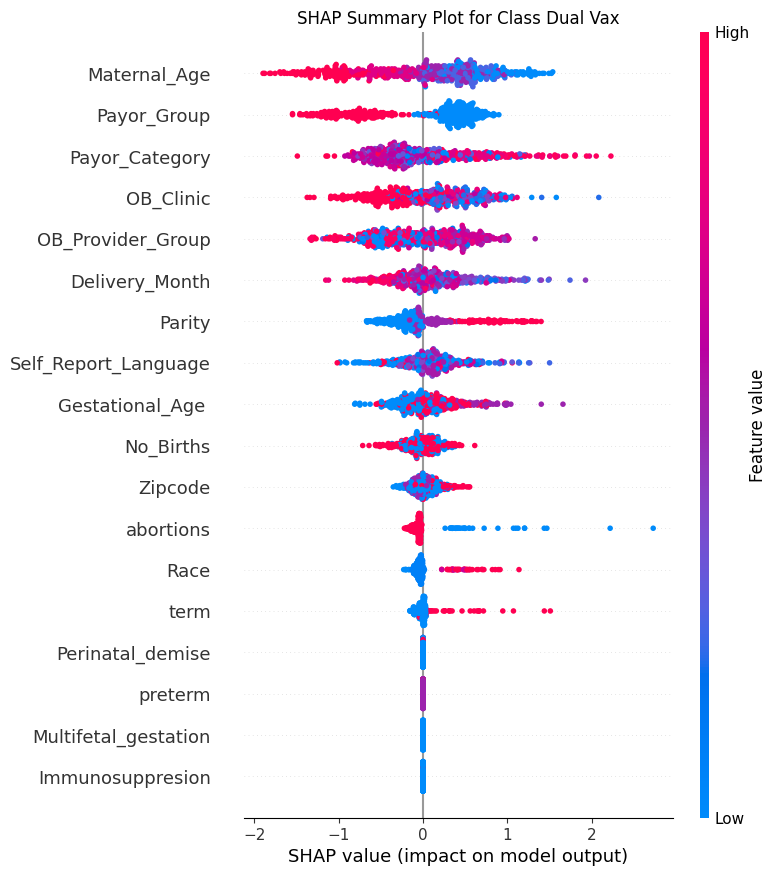

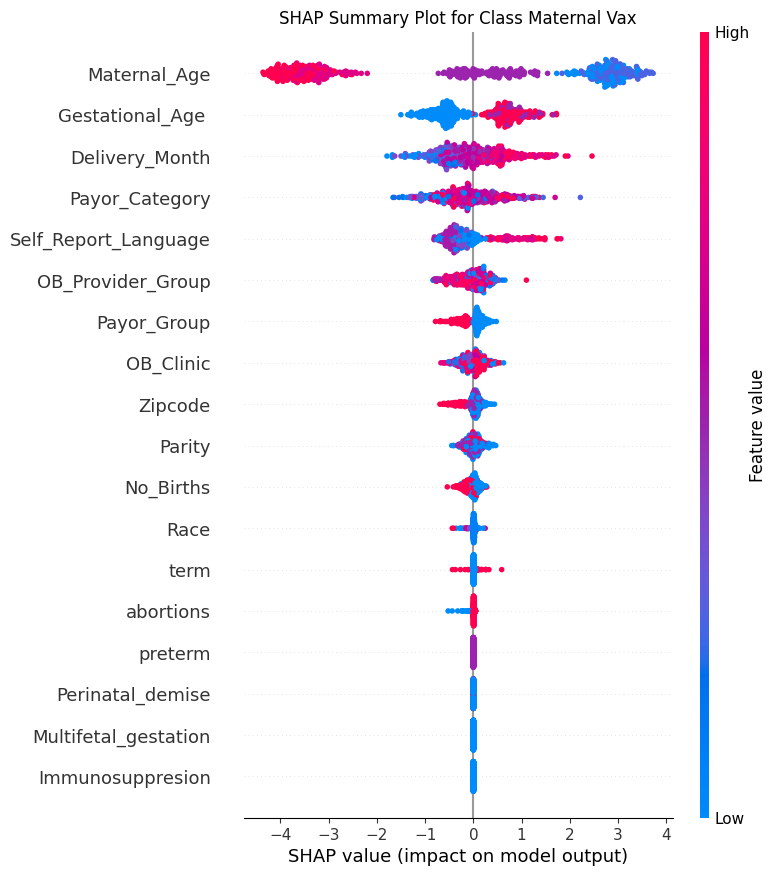

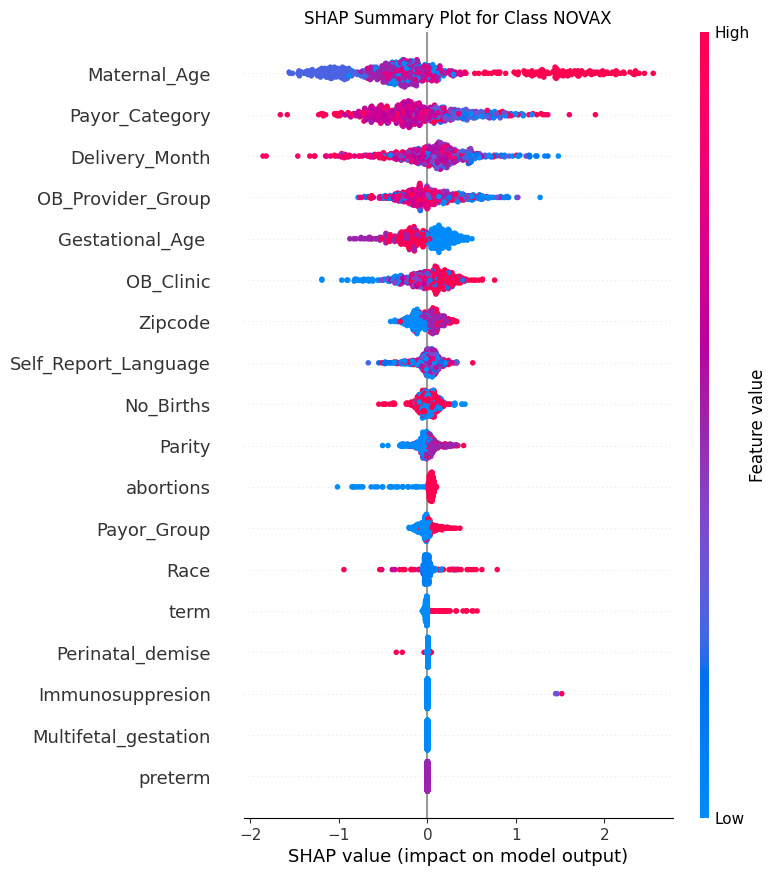

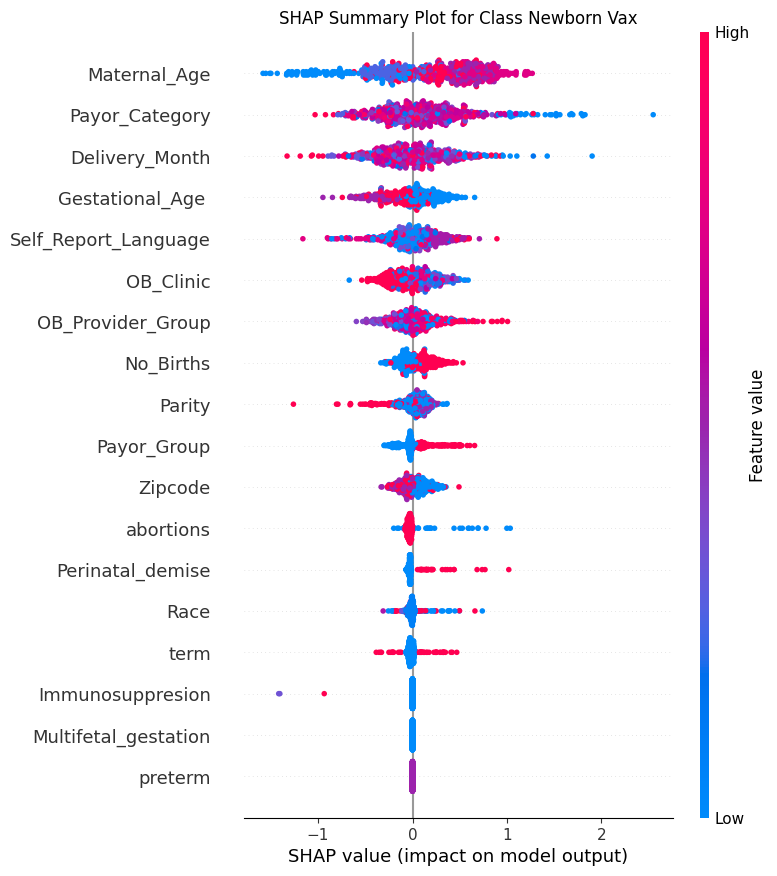

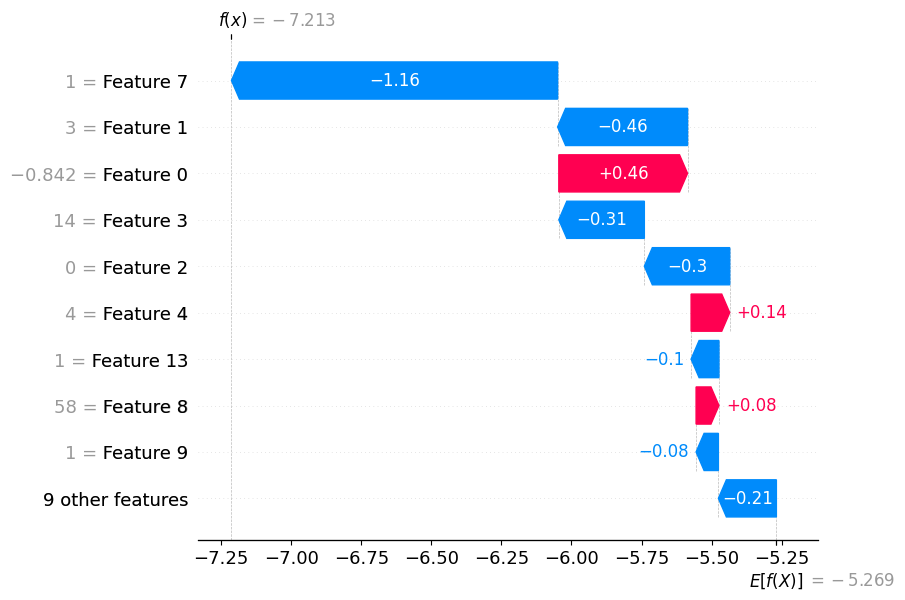

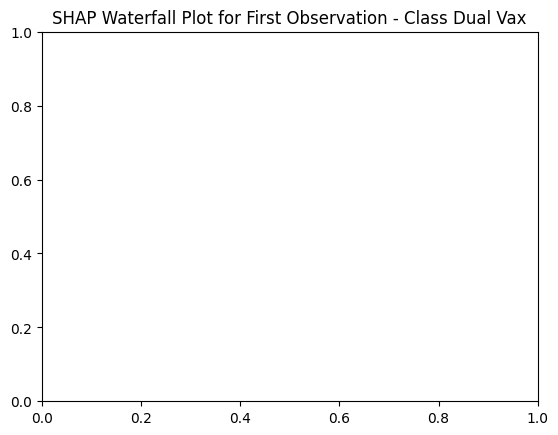

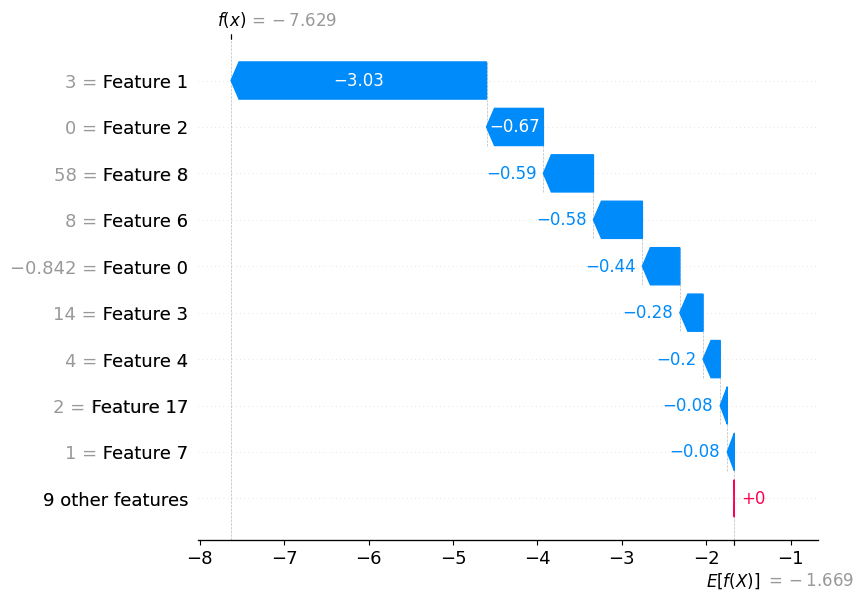

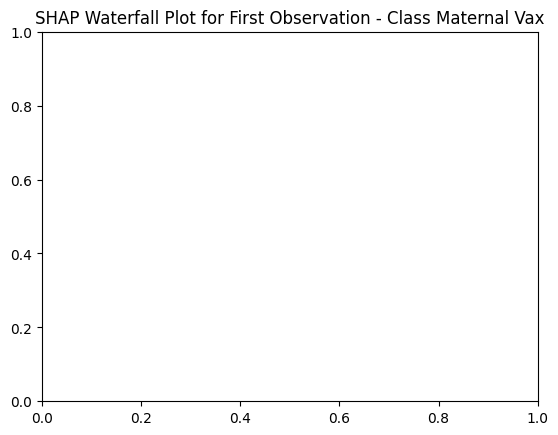

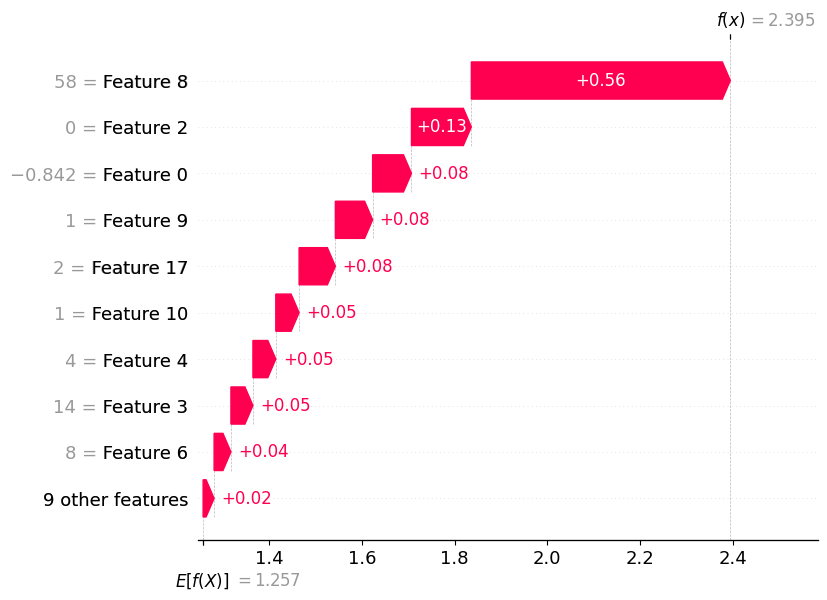

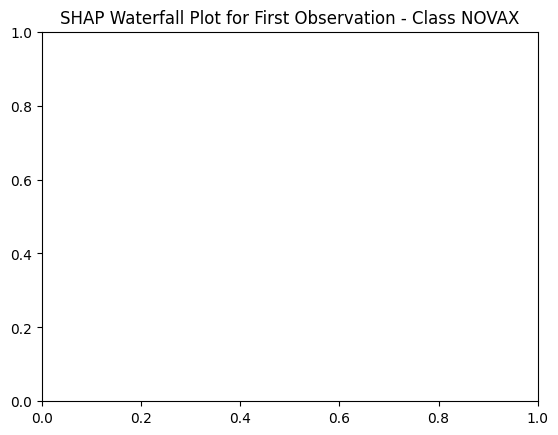

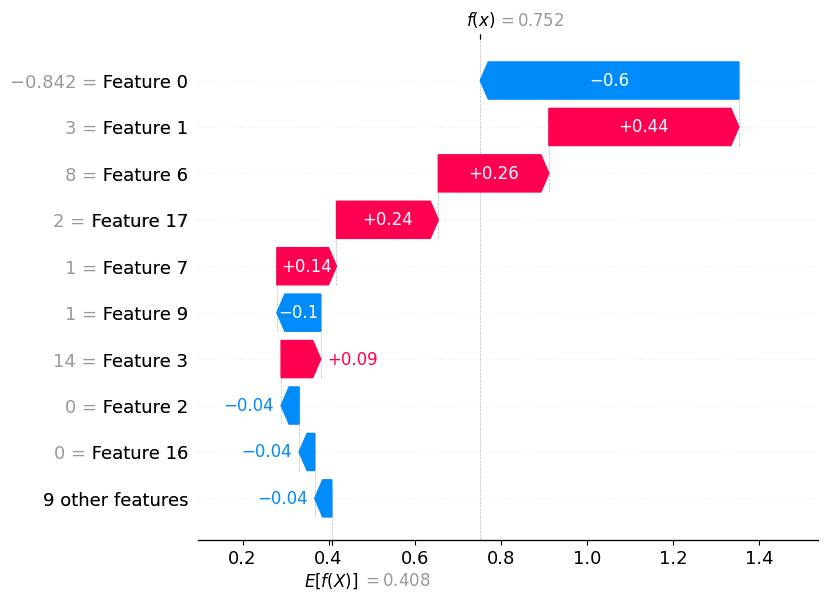

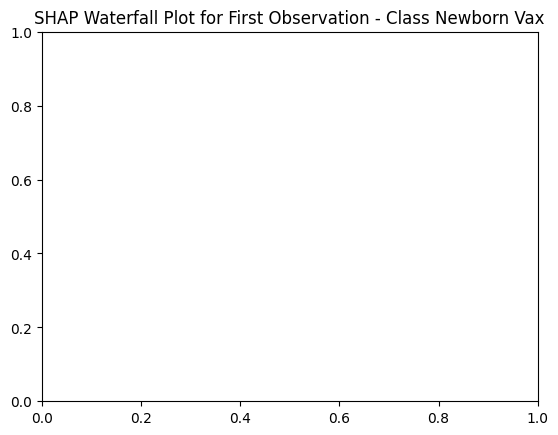

In [ ]:
xgb_model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_resampled, y_train_resampled)

# Create the SHAP explainer
explainer = shap.Explainer(xgb_model, X_train_preprocessed)
shap_values = explainer(X_test_preprocessed)

# Ensure feature names are correctly passed to SHAP summary plot
feature_names = X.columns.tolist()

# Visualize SHAP values for each class separately
for i, class_name in enumerate(class_names):
    plt.figure()
    shap.summary_plot(shap_values[:, :, i], X_test_preprocessed, feature_names=feature_names, show=False)
    plt.title(f'SHAP Summary Plot for Class {class_name}')
    plt.show()

# Waterfall plot for the first observation in the test set for each class
for i, class_name in enumerate(class_names):
    shap.waterfall_plot(shap_values[0][:, i])
    plt.title(f'SHAP Waterfall Plot for First Observation - Class {class_name}')
    plt.show()

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4cccc50569bbeaec9bebfd2d6af6d65963cdd7169cd27e9edf40ae5ebea60d2b
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
# Train the XGBoost model
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Get feature names
feature_names = preprocessor.get_feature_names_out()

In [ ]:
import shap


In [ ]:
# Initialize JS for SHAP plots
shap.initjs()

# Function to explain the XGBoost model
def explain_xgb(model, x_test, feature_names):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_test)
    shap_values_combined = np.mean(np.abs(shap_values), axis=0)
    print(f"SHAP values shape: {shap_values_combined.shape}, Data shape: {x_test.shape}")
    shap.summary_plot(shap_values_combined, x_test, plot_type="bar", feature_names=feature_names)

# Explain the XGBoost model
explain_xgb(xgb_model, X_test_preprocessed, feature_names)

SHAP values shape: (18, 4), Data shape: (587, 18)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [ ]:
# SHAP Force Plot
def plot_force_plot_xgb(model, x_test, shap_values, feature_names, observation_index):
    explainer = shap.TreeExplainer(model)
    shap_values_single = shap_values[observation_index]  # Get SHAP values for the specific observation
    x_test_single = x_test[observation_index].reshape(1, -1)  # Reshape to 2D array
    shap.force_plot(explainer.expected_value, shap_values_single, x_test_single, feature_names=feature_names)

# Plot SHAP force plot for a specific observation (XGBoost)
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test_preprocessed)
observation_index = 8  # Example index
plot_force_plot_xgb(xgb_model, X_test_preprocessed, shap_values_xgb, feature_names, observation_index)

IndexError: index 1 is out of bounds for axis 0 with size 1